# Abalone Regression

## Import Statements and Functions

In [111]:
import requests
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 

from autogluon.tabular import TabularDataset, TabularPredictor

import boto3
import pickle

In [55]:
# Function for uploading directories
# Source: https://www.developerfiles.com/upload-files-to-s3-with-python-keeping-the-original-folder-structure/
def upload_files(s3, bucket_name, path, prefix):
    bucket = s3.Bucket(bucket_name)
    for subdir, dirs, files in os.walk(path):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=prefix+full_path[len(path)+1:], Body=data)

In [56]:
# Custom Heatmap Plot
# Source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def corr_plot(df):
    corr = df.corr(numeric_only=True)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 10))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 11, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [57]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
data_response = requests.get(url)

directory = 'data/'
file_name = 'abalone.csv'
with open(directory+file_name, 'wb') as f:
    f.write(data_response.content)

In [58]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names'
context_response = requests.get(url)

directory = 'data/'
file_name = 'description.txt'
with open(directory+file_name, 'wb') as f:
    f.write(context_response.content)

## Read Data

In [59]:
columns = ['sex', 'length', 'diameter', 'height', 'whole_weight',
           'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
df = pd.read_csv('data/abalone.csv', header=None, names=columns)
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Try it out with .parquet format

In [60]:
table = pa.Table.from_pandas(df)
pq.write_table(table, 'data/abalone.parquet')
df_parquet = pd.read_parquet('data/abalone.parquet')
df_parquet.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Save Data to AWS S3

In [61]:
secret = (os.getenv('AWS_SECRET_ACCESS_KEY'))
key_id = (os.getenv('AWS_ACCESS_KEY_ID'))
bucket_name = (os.getenv('AWS_BUCKET'))

In [62]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=key_id,
    aws_secret_access_key=secret
)

In [63]:
s3.Bucket(bucket_name).upload_file(Filename='data/abalone.csv', Key='abalone/data/abalone.csv')

## Initial Exploratory Data Analysis

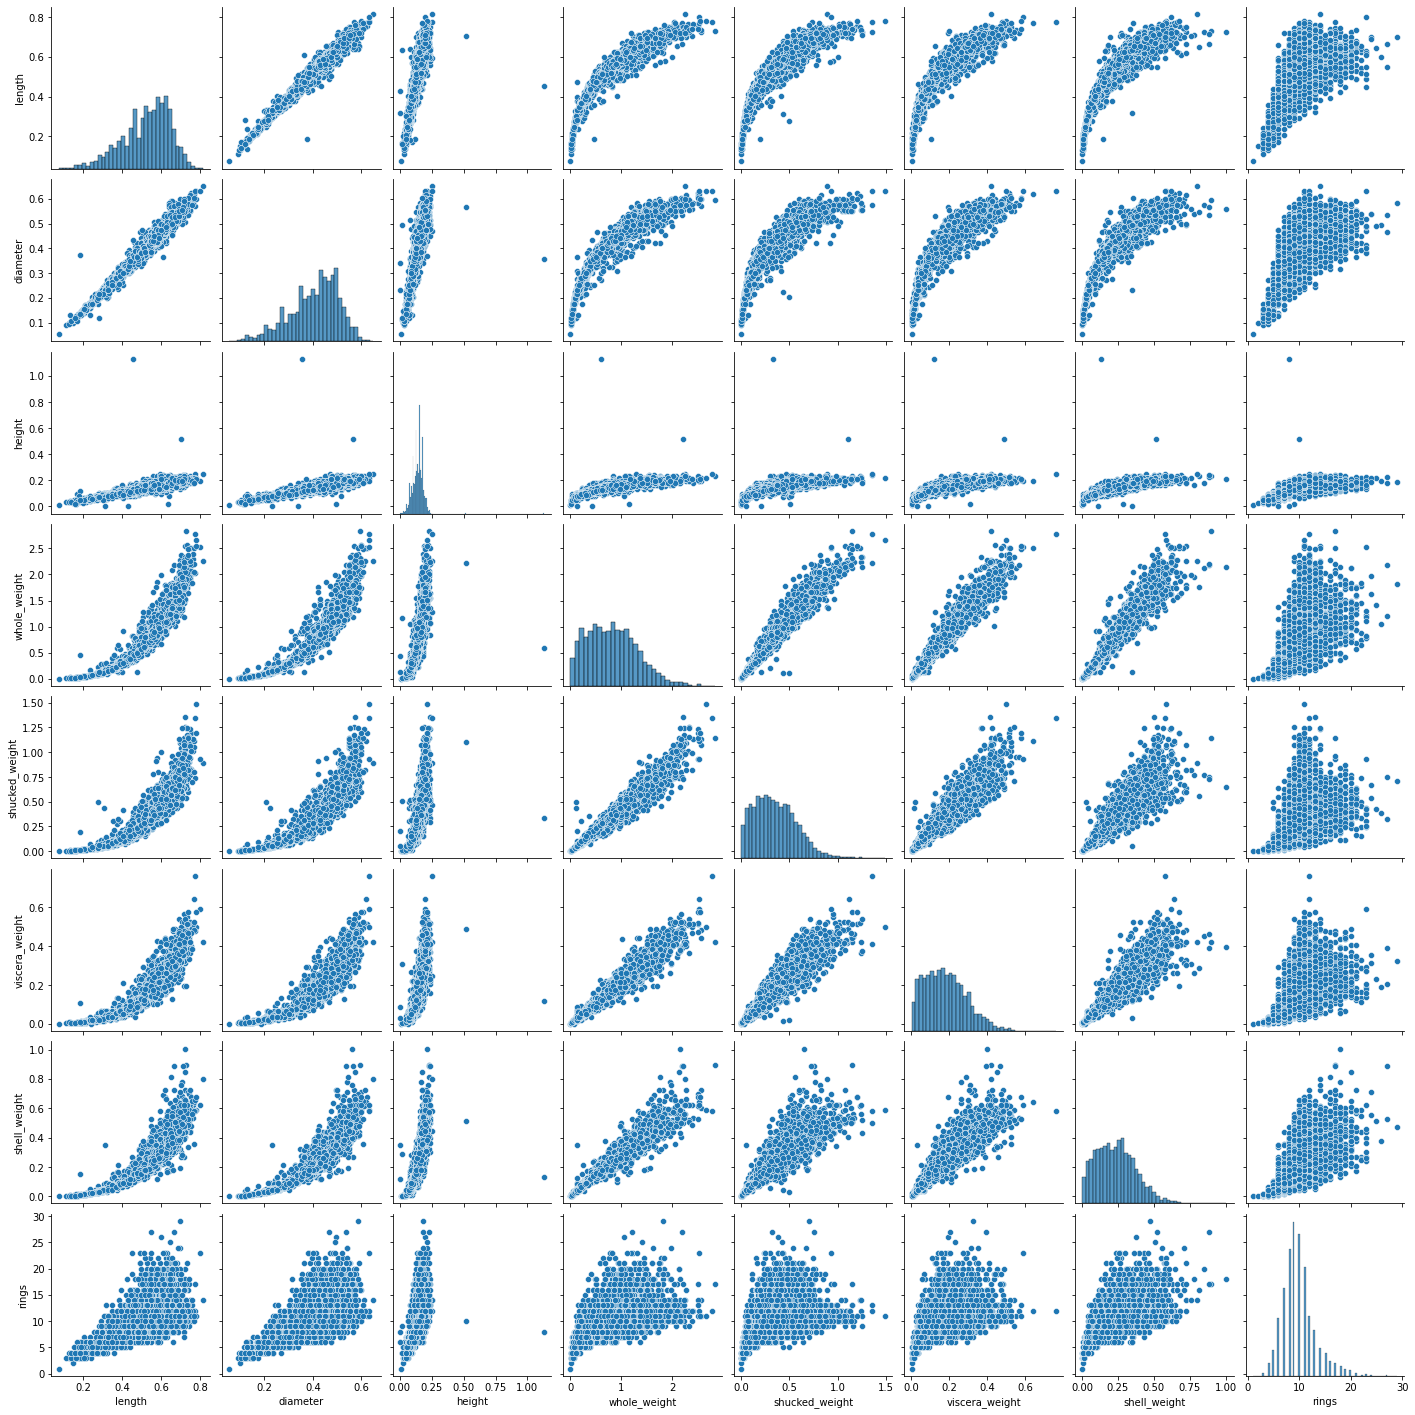

In [64]:
df_eda = df.copy()
sns.pairplot(df_eda)

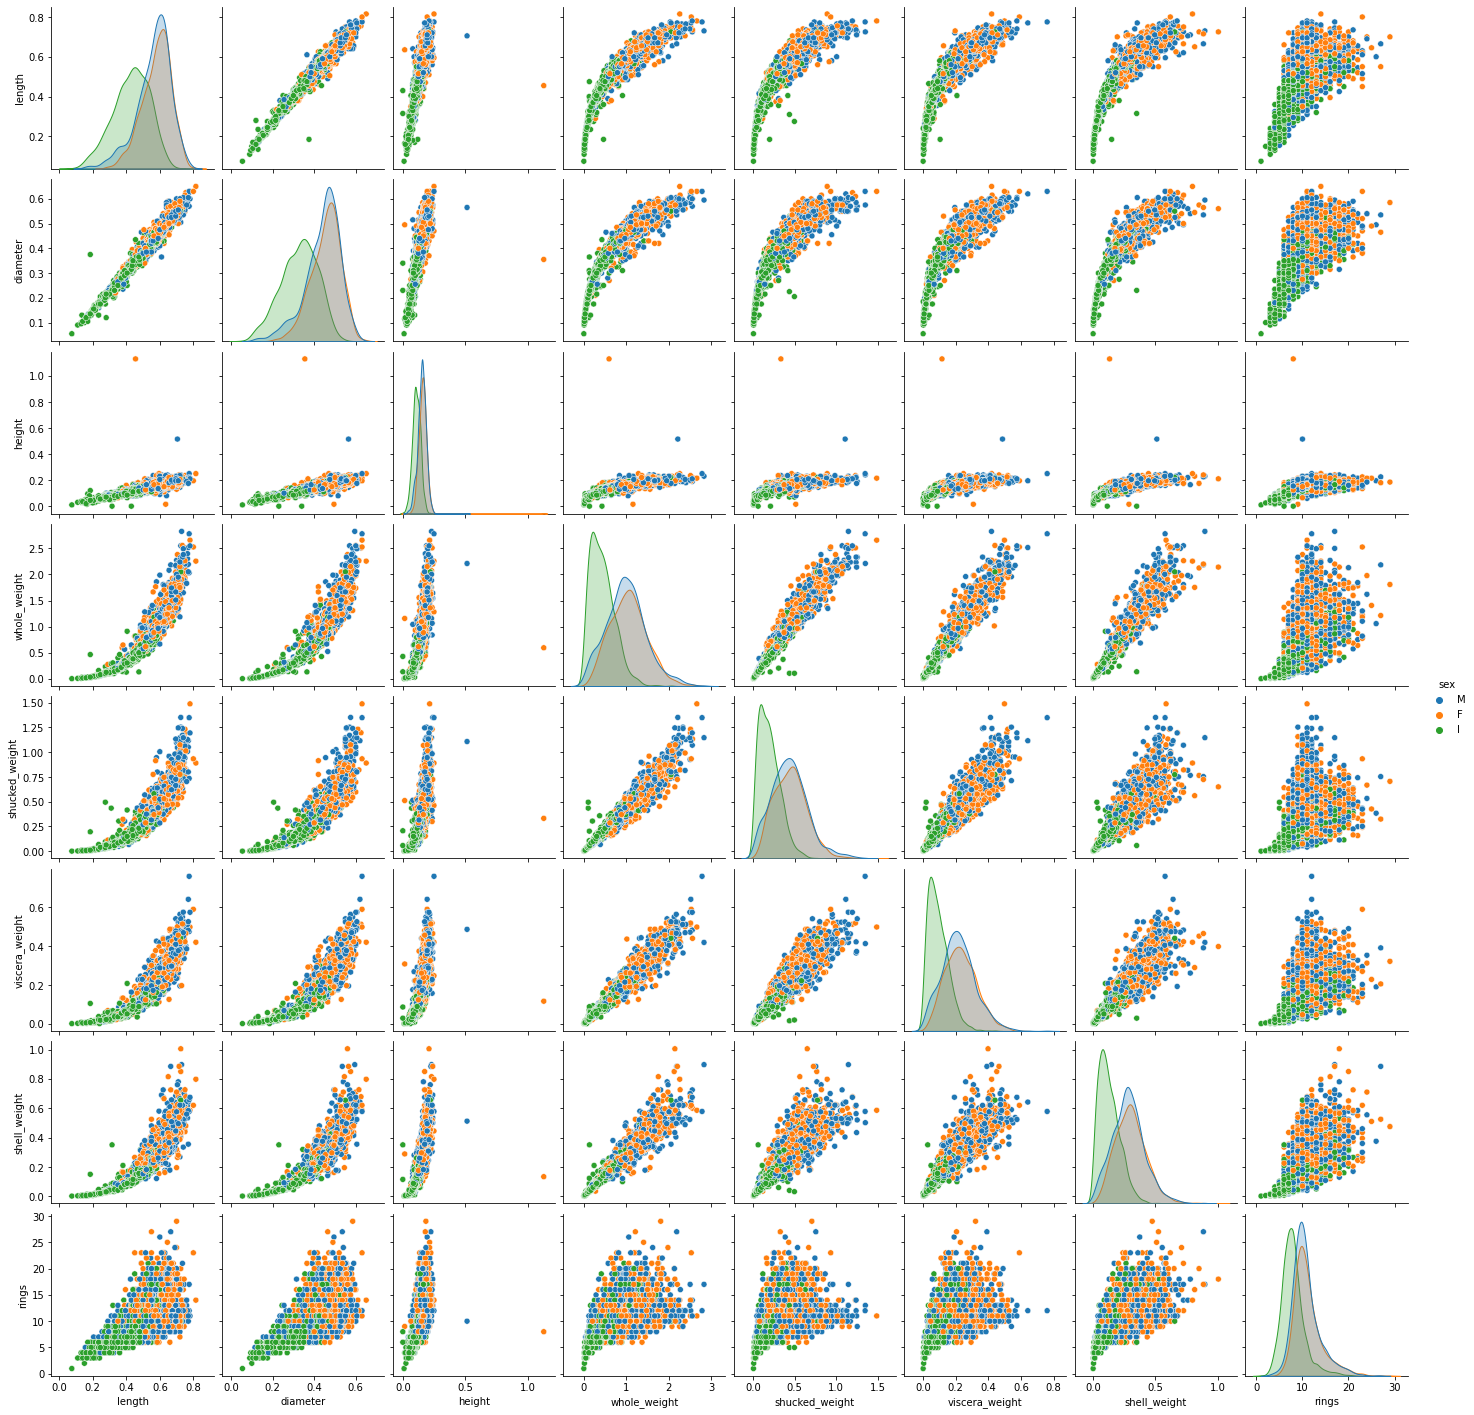

In [65]:
sns.pairplot(df_eda, hue='sex')

<AxesSubplot: >

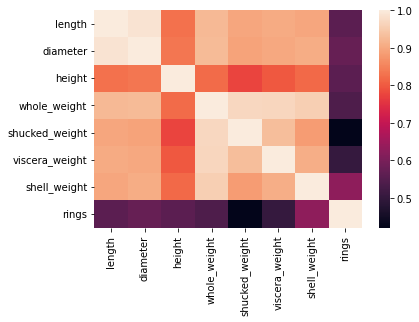

In [66]:
sns.heatmap(df_eda.corr(numeric_only=True))

### Explore PCA for Dimensionality Reduction

In [67]:
pca = PCA(n_components=1)
scaler = StandardScaler()

df_eda['pca_1'] = pca.fit_transform(scaler.fit_transform(df_eda.drop(columns=['rings','sex'])))
df_eda.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,pca_1
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,-1.756019
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,-3.362734
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,-0.482338
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,-1.509041
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,-3.654006


<AxesSubplot: xlabel='pca_1', ylabel='rings'>

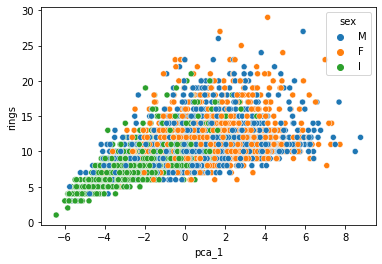

In [68]:
sns.scatterplot(data=df_eda, x='pca_1', y='rings', hue='sex')

<AxesSubplot: xlabel='pca_2_1', ylabel='pca_2_2'>

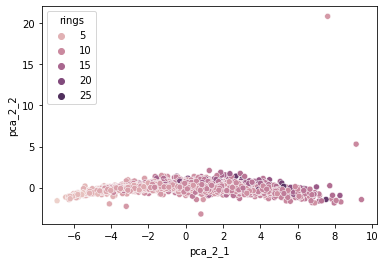

In [69]:
pca_2 = PCA(n_components=2)
scaler = StandardScaler()

df_eda[['pca_2_1', 'pca_2_2']] = pca_2.fit_transform(scaler.fit_transform(df_eda.drop(columns=['rings','sex'])))
sns.scatterplot(data=df_eda, x='pca_2_1', y='pca_2_2', hue='rings')

<AxesSubplot: xlabel='rings', ylabel='Count'>

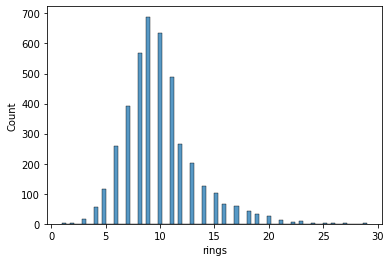

In [70]:
sns.histplot(data=df_eda, x='rings')

## Initial Predictive Model Building

### build features and split data

In [71]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [72]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=42)

In [73]:
train_data = TabularDataset(df_train)

In [74]:
label = 'rings'
print("Summary of class variable: \n", train_data[label].describe())

Summary of class variable: 
 count    3341.000000
mean        9.944627
std         3.207344
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: rings, dtype: float64


In [75]:
regression_predictor = TabularPredictor(label=label,
                                        path='ag_models/abalone-regression-model',
                                        problem_type='regression').fit(train_data)

Beginning AutoGluon training ...
AutoGluon will save models to "ag_models/abalone-regression-model/"
AutoGluon Version:  0.6.1
Python Version:     3.9.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    3341
Train Data Columns: 8
Label Column: rings
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    13525.82 MB
	Train Data (Original)  Memory Usage: 0.38 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fittin

[1000]	valid_set's rmse: 2.23757


	-2.2355	 = Validation score   (-root_mean_squared_error)
	3.2s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBM ...
	-2.2425	 = Validation score   (-root_mean_squared_error)
	1.75s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-2.2372	 = Validation score   (-root_mean_squared_error)
	2.9s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: CatBoost ...
	-2.2362	 = Validation score   (-root_mean_squared_error)
	3.88s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-2.238	 = Validation score   (-root_mean_squared_error)
	1.67s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-2.1822	 = Validation score   (-root_mean_squared_error)
	8.56s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	-2.258	 = Validation score   (-root_mean_squared_error)
	1.02s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting

In [76]:
predictor = TabularPredictor.load("ag_models/abalone-regression-model/")
df_test['predicted_rings'] = predictor.predict(df_test.drop(columns='rings'))
df_test['residual_error'] = df['rings'] - df_test['predicted_rings']

<AxesSubplot: xlabel='residual_error', ylabel='Count'>

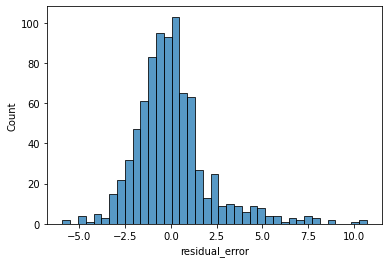

In [77]:
sns.histplot(df_test.residual_error)

In [78]:
distilled_model_names = predictor.distill()
ldr = predictor.leaderboard(df_test)
model_to_deploy = distilled_model_names[0]
distlled_preds = predictor.predict(df_test.drop(columns='rings'), model=model_to_deploy)

Distilling with teacher='WeightedEnsemble_L2', teacher_preds=soft, augment_method=spunge ...
SPUNGE: Augmenting training data with 14205 synthetic samples for distillation...
Distilling with each of these student models: ['LightGBM_DSTL', 'NeuralNetMXNet_DSTL', 'CatBoost_DSTL', 'RandomForest_DSTL', 'NeuralNetTorch_DSTL']
Fitting 5 L1 models ...
Fitting model: LightGBM_DSTL ...
	-2.1819	 = Validation score   (-root_mean_squared_error)
	3.09s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetMXNet_DSTL ...
		Unable to import dependency mxnet. A quick tip is to install via `pip install mxnet --upgrade`, or `pip install mxnet_cu101 --upgrade`
Fitting model: CatBoost_DSTL ...
	-2.1832	 = Validation score   (-root_mean_squared_error)
	8.58s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForest_DSTL ...
	-2.1973	 = Validation score   (-root_mean_squared_error)
	17.15s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: NeuralNetTo

                       model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            NeuralNetFastAI   -2.091416  -2.182202        0.077994       0.044722   8.560314                 0.077994                0.044722           8.560314            1       True          8
1   WeightedEnsemble_L2_DSTL   -2.108320  -2.158734        1.001581       0.216105  55.767184                 0.004055                0.000648           0.321041            2       True         17
2        NeuralNetTorch_DSTL   -2.109234  -2.163447        0.061422       0.021618  35.211981                 0.061422                0.021618          35.211981            1       True         16
3        WeightedEnsemble_L2   -2.119194  -2.153730        0.463673       0.328392  29.620847                 0.015863                0.000637           0.595386            2       True         12
4              

## Store Models

In [79]:
upload_files(s3=s3,
             bucket_name=bucket_name,
             path='./ag_models/abalone-regression-model',
             prefix='abalone/autogluon-models/')

## Evaluate Distilled Models

In [80]:
distilled_model_names

['LightGBM_DSTL',
 'CatBoost_DSTL',
 'RandomForest_DSTL',
 'NeuralNetTorch_DSTL',
 'WeightedEnsemble_L2_DSTL']

In [81]:
ldr

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetFastAI,-2.091416,-2.182202,0.077994,0.044722,8.560314,0.077994,0.044722,8.560314,1,True,8
1,WeightedEnsemble_L2_DSTL,-2.108320,-2.158734,1.001581,0.216105,55.767184,0.004055,0.000648,0.321041,2,True,17
2,NeuralNetTorch_DSTL,-2.109234,-2.163447,0.061422,0.021618,35.211981,0.061422,0.021618,35.211981,1,True,16
3,WeightedEnsemble_L2,-2.119194,-2.153730,0.463673,0.328392,29.620847,0.015863,0.000637,0.595386,2,True,12
4,LightGBM_DSTL,-2.145012,-2.181895,0.043034,0.023955,3.087645,0.043034,0.023955,3.087645,1,True,13
5,RandomForest_DSTL,-2.152934,-2.197344,0.893070,0.169885,17.146517,0.893070,0.169885,17.146517,1,True,15
6,NeuralNetTorch,-2.153291,-2.187987,0.050101,0.028813,17.545934,0.050101,0.028813,17.545934,1,True,10
7,CatBoost_DSTL,-2.153774,-2.183247,0.010206,0.004879,8.579627,0.010206,0.004879,8.579627,1,True,14
8,LightGBMXT,-2.208620,-2.235475,0.094487,0.049809,3.197531,0.094487,0.049809,3.197531,1,True,3
9,CatBoost,-2.225744,-2.236232,0.014465,0.003838,3.876833,0.014465,0.003838,3.876833,1,True,6


In [82]:
ldr.loc[0,:]

model                      NeuralNetFastAI
score_test                       -2.091416
score_val                        -2.182202
pred_time_test                    0.077994
pred_time_val                     0.044722
fit_time                          8.560314
pred_time_test_marginal           0.077994
pred_time_val_marginal            0.044722
fit_time_marginal                 8.560314
stack_level                              1
can_infer                             True
fit_order                                8
Name: 0, dtype: object

In [83]:
distilled_model_names[0]

'LightGBM_DSTL'

In [84]:
print(os.getcwd())

/home/studio-lab-user/abalone-regression


In [88]:
df_test

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,predicted_rings,residual_error
866,M,0.605,0.455,0.160,1.1035,0.4210,0.3015,0.325,9,11.776371,-2.776371
1483,M,0.590,0.440,0.150,0.8725,0.3870,0.2150,0.245,8,9.120620,-1.120620
599,F,0.560,0.445,0.195,0.9810,0.3050,0.2245,0.335,16,15.181332,0.818668
1702,F,0.635,0.490,0.170,1.2615,0.5385,0.2665,0.380,9,11.036966,-2.036966
670,M,0.475,0.385,0.145,0.6175,0.2350,0.1080,0.215,14,12.325089,1.674911
...,...,...,...,...,...,...,...,...,...,...,...
3093,F,0.520,0.430,0.150,0.7280,0.3020,0.1575,0.235,11,10.833330,0.166670
1651,F,0.595,0.435,0.150,0.9000,0.4175,0.1700,0.265,8,9.678307,-1.678307
2897,I,0.545,0.430,0.150,0.7420,0.3525,0.1580,0.208,10,9.158061,0.841939
3953,I,0.465,0.355,0.120,0.5805,0.2550,0.0915,0.184,8,9.225357,-1.225357


In [85]:
model_dir = f'ag_models/abalone-regression-model/models/{distilled_model_names[0]}/model.pkl'

In [86]:
model = pickle.load(open(model_dir, 'rb'))

In [96]:
model.get_features()

['length',
 'diameter',
 'height',
 'whole_weight',
 'shucked_weight',
 'viscera_weight',
 'shell_weight',
 'sex']

In [109]:
df_test_input = df_test[columns].drop(columns='rings')
df_test_input = df_test_input[list(model.get_features())]
df_test_input.sex = df_test_input.sex.astype('category')
# df_test_input.columns
df_test['single_model_preds'] = model.predict_proba(df_test_input)

In [110]:
df_test.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,predicted_rings,residual_error,single_model_preds
866,M,0.605,0.455,0.160,1.1035,0.4210,0.3015,0.325,9,11.776371,-2.776371,12.442447
1483,M,0.590,0.440,0.150,0.8725,0.3870,0.2150,0.245,8,9.120620,-1.120620,9.598480
599,F,0.560,0.445,0.195,0.9810,0.3050,0.2245,0.335,16,15.181332,0.818668,15.292471
1702,F,0.635,0.490,0.170,1.2615,0.5385,0.2665,0.380,9,11.036966,-2.036966,11.194815
670,M,0.475,0.385,0.145,0.6175,0.2350,0.1080,0.215,14,12.325089,1.674911,11.958513


In [115]:
df_test['distilled_preds'] = predictor.predict(df_test[columns].drop(columns='rings'), model=model_to_deploy)

In [117]:
ag_mse = mean_squared_error(df_test.rings, df_test.predicted_rings, squared = False)
single_model_mse = mean_squared_error(df_test.rings, df_test.single_model_preds, squared = False)
ag_distilled_mse = mean_squared_error(df_test.rings, df_test.distilled_preds, squared = False)

In [120]:
print(ag_mse)
print(single_model_mse)
print(ag_distilled_mse)

2.119194433207523
2.182120520805119
2.145012171325599


In [116]:
df_test.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,predicted_rings,residual_error,single_model_preds,distilled_preds
866,M,0.605,0.455,0.160,1.1035,0.4210,0.3015,0.325,9,11.776371,-2.776371,12.442447,12.451392
1483,M,0.590,0.440,0.150,0.8725,0.3870,0.2150,0.245,8,9.120620,-1.120620,9.598480,9.598480
599,F,0.560,0.445,0.195,0.9810,0.3050,0.2245,0.335,16,15.181332,0.818668,15.292471,15.072639
1702,F,0.635,0.490,0.170,1.2615,0.5385,0.2665,0.380,9,11.036966,-2.036966,11.194815,10.839717
670,M,0.475,0.385,0.145,0.6175,0.2350,0.1080,0.215,14,12.325089,1.674911,11.958513,11.933918
